# 1. Camera calibration

In [1]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib qt

In [2]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

nx=9
ny=6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow('ChessboardCorners',img)
        cv2.waitKey(500)
    
cv2.destroyAllWindows()

## 1.1 Distorsion correction applied on test_images

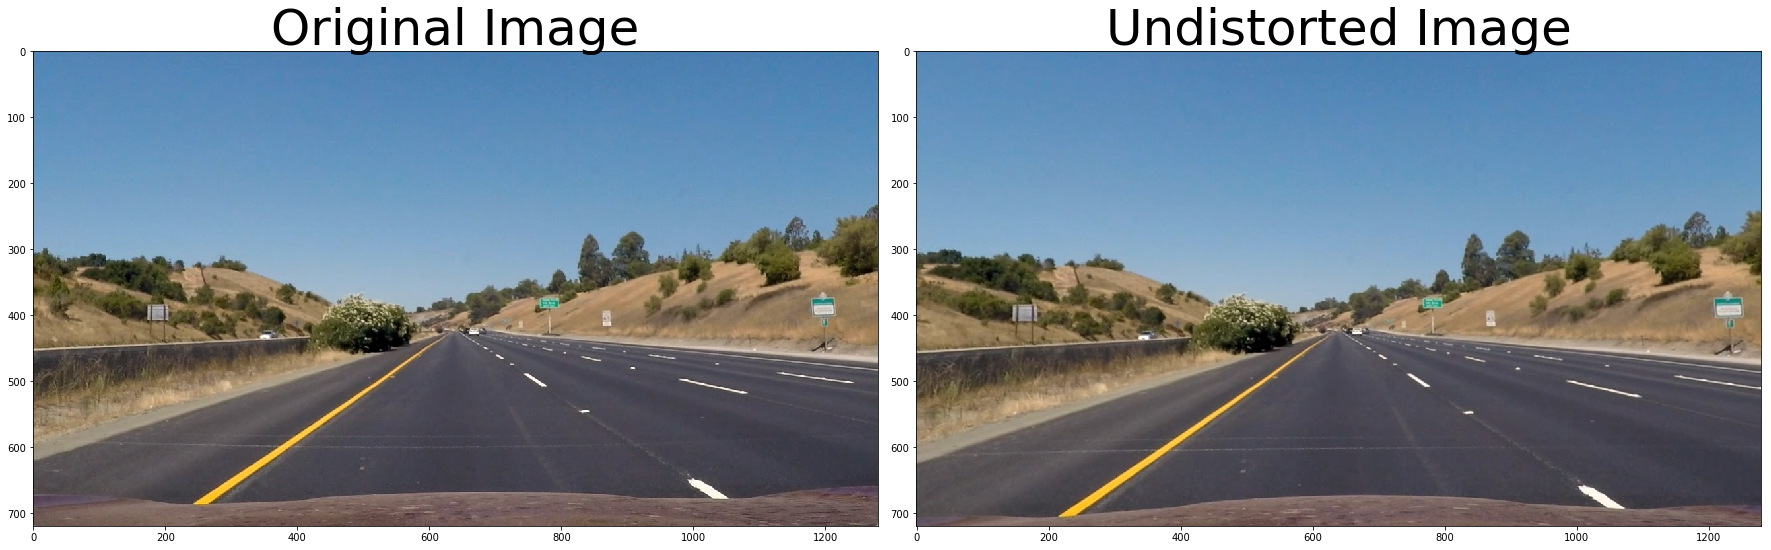

In [3]:
dist_img = cv2.imread('test_images/straight_lines1.jpg')
dist_img = cv2.cvtColor(dist_img, cv2.COLOR_BGR2RGB)
gray_dist = cv2.cvtColor(dist_img,cv2.COLOR_RGB2GRAY)
img_size = (dist_img.shape[1], dist_img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
undistorted = cv2.undistort(dist_img, mtx, dist, None, mtx) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(dist_img)
f.tight_layout()
ax1.imshow(dist_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/original_undistored.jpg')

cm_dict = {'mtx': mtx, 'dist': dist}
with open('camera_matrix.p', 'wb') as f:
    pickle.dump(cm_dict, f)

images = os.listdir("test_images/")
for fname in images:
    img = cv2.imread(os.path.join('test_images/', fname))
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite(os.path.join('output_images/', 'undistorted_' + fname), undist );

## 2. Image Thresholding

In [4]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def combined_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    ksize = 3

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    #grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(50, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls_bin = hls_select(img, thresh=(170,255))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | hls_bin == 1] = 1
    return combined

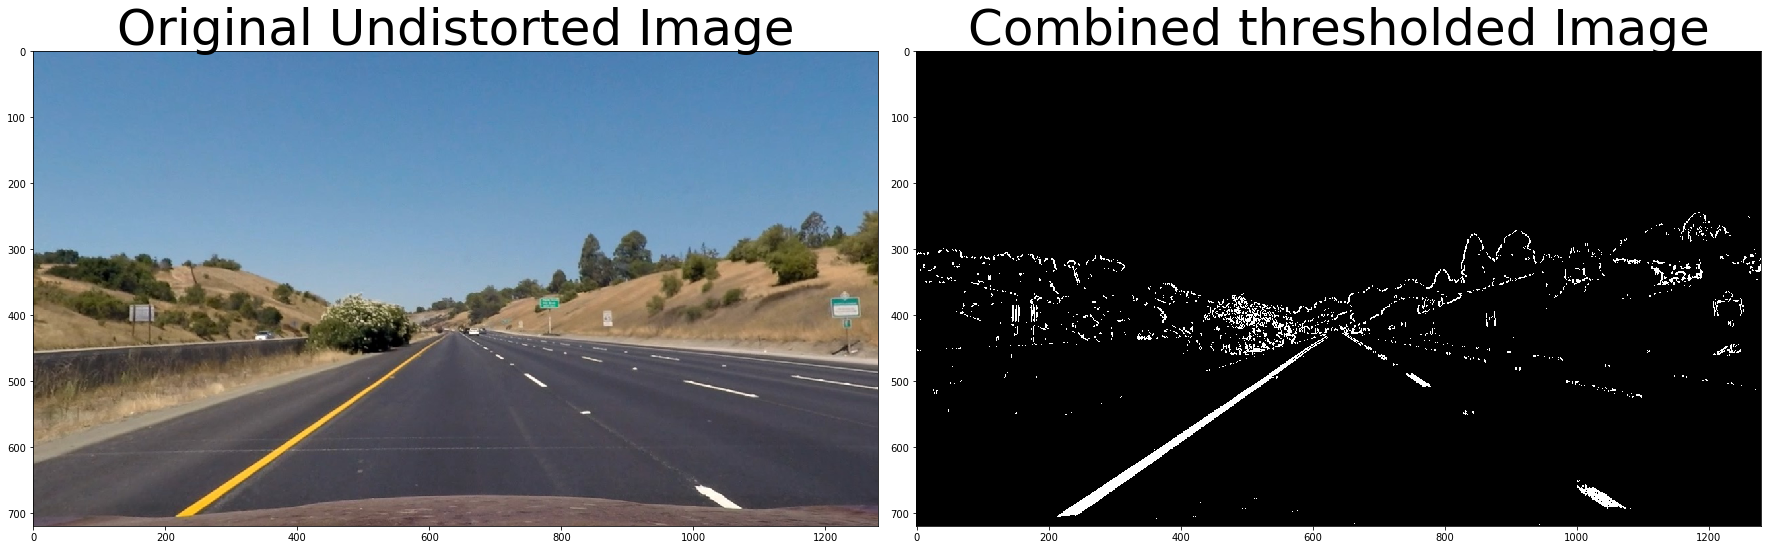

In [5]:
combined = combined_threshold(undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(dist_img)
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Undistorted Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined thresholded Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/original_undistored_thresholded.jpg')

## 2.1 Perspective transform

In [6]:
def perspective_transform(img):
    """
    Execute perspective transform
    """
    img_size = (img.shape[1], img.shape[0])

    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    m = cv2.getPerspectiveTransform(src, dst)
    m_inv = cv2.getPerspectiveTransform(dst, src)
  
    warped = cv2.warpPerspective(img, m, img_size, flags=cv2.INTER_LINEAR)
    unwarped = cv2.warpPerspective(warped, m_inv, (warped.shape[1], warped.shape[0]), flags=cv2.INTER_LINEAR)  # DEBUG

    return warped, unwarped, m, m_inv

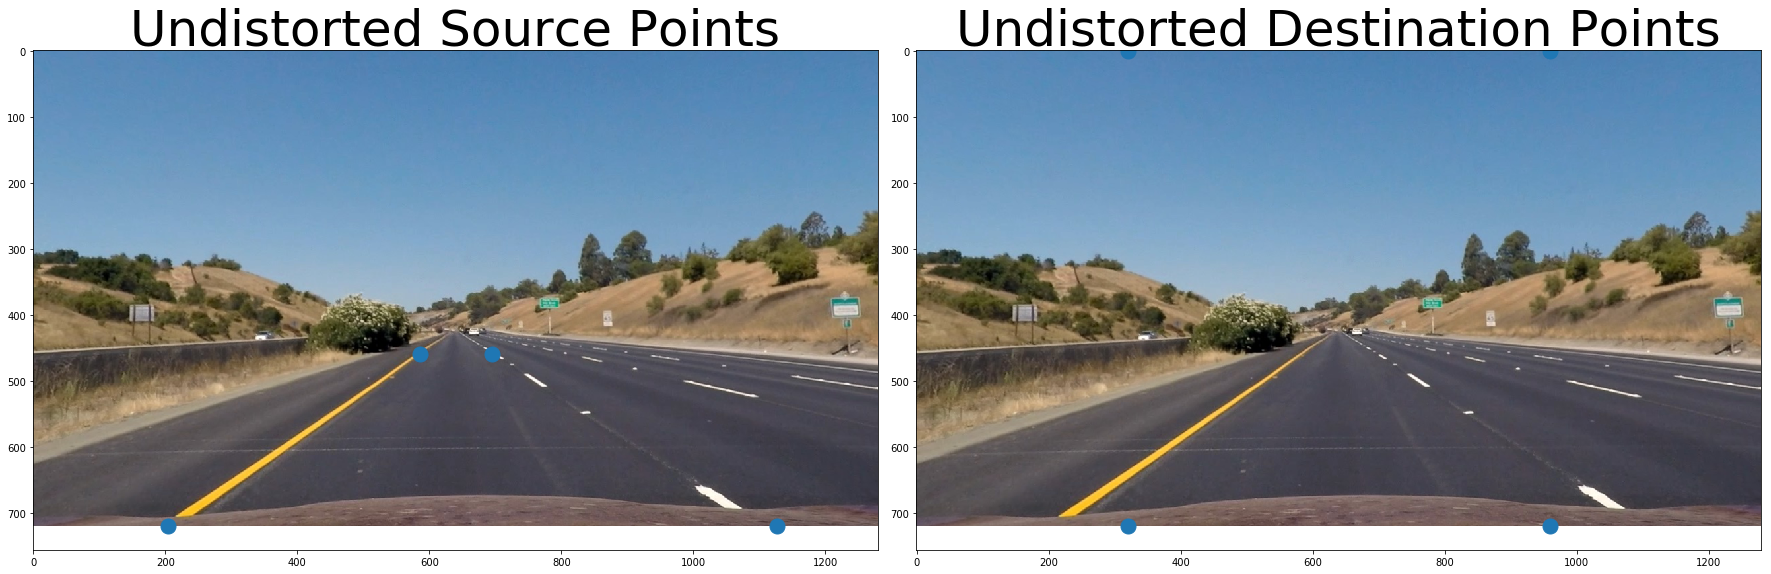

In [7]:
img_size = (undistorted.shape[1],undistorted.shape[0])

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(undistorted)
ax1.plot(src[:,0],src[:,1], '.',markersize=30)
f.tight_layout()
ax1.set_title('Undistorted Source Points', fontsize=50)
ax2.imshow(undistorted)
ax2.plot(dst[:,0],dst[:,1], '.',markersize=30)
ax2.set_title('Undistorted Destination Points', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/undistored_perpsective_points.jpg')

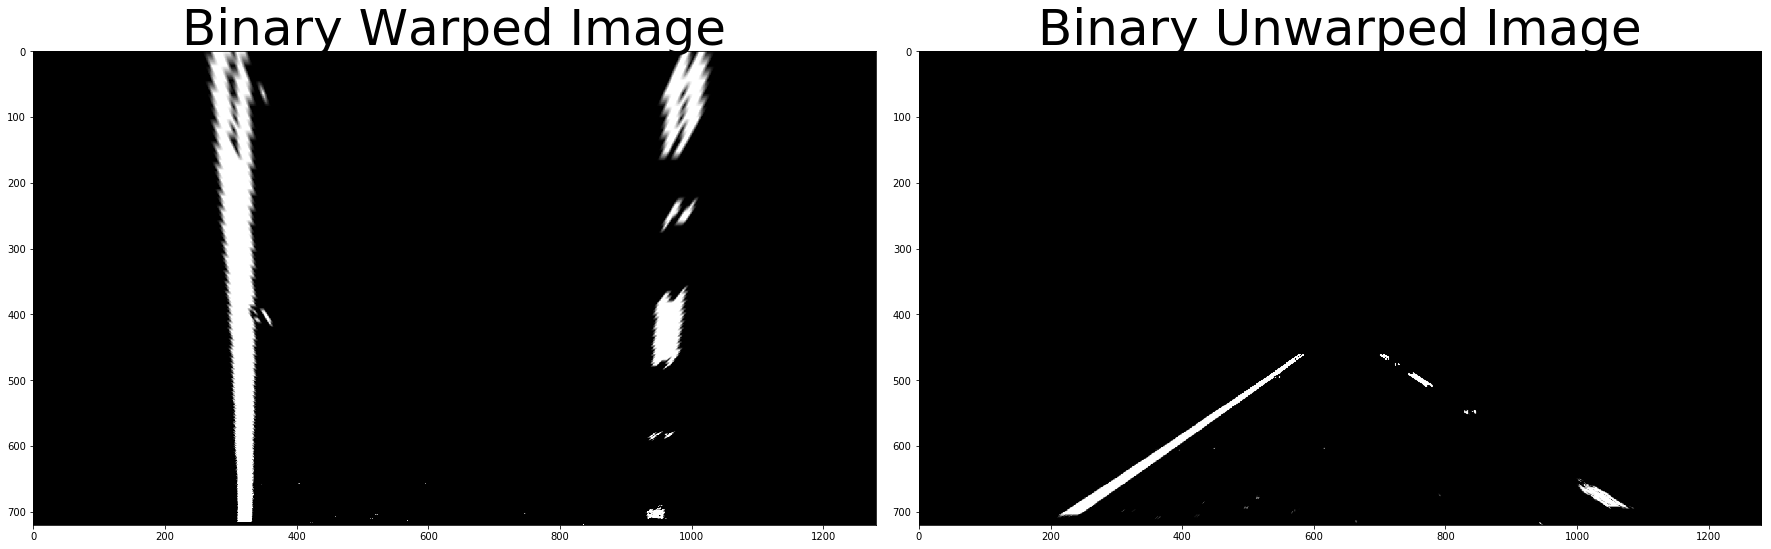

In [8]:
import matplotlib.image as mpimg

warped, unwarped, m, m_inv = perspective_transform(combined)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped, cmap='gray')
ax1.set_title('Binary Warped Image', fontsize=50)
ax2.imshow(unwarped, cmap='gray')
ax2.set_title('Binary Unwarped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/warped_unwarped.jpg')

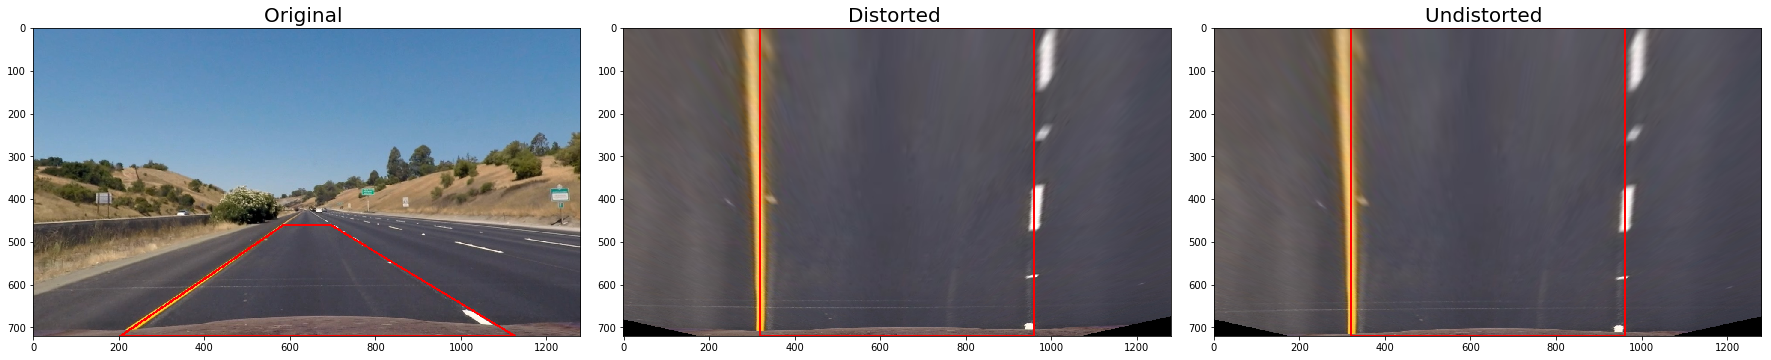

In [9]:
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

# Transform points to draw lines
pts_src = np.asarray(src).astype(int)  
pts_dst = np.asarray(dst).astype(int) 

new_distorted = plt.imread('test_images/straight_lines1.jpg')
new_undistorted = cv2.undistort(new_distorted, mtx, dist, None, mtx)
new_warped, new_unwarped, m, m_inv = perspective_transform(new_undistorted)
new_warped_distr, new_unwarped_distr, m, m_inv = perspective_transform(new_distorted)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

cv2.polylines(new_undistorted,[pts_src],True,(255,0,0), thickness=3,)   
cv2.polylines(new_warped,[pts_dst],True,(255,0,0), thickness=3,)
cv2.polylines(new_warped_distr,[pts_dst],True,(255,0,0), thickness=3,)
ax1.imshow(new_undistorted)
ax1.set_title('Original ', fontsize=20)
ax2.imshow(new_warped_distr)
ax2.set_title('Distorted ', fontsize=20)
ax3.imshow(new_warped)
ax3.set_title('Undistorted ', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/lines_orig_udist.jpg')

## 3.  Lane Detection

In [10]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
   
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def search_around_poly(binary_warped, left_fit, right_fit):
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty

def fit_polynomial(leftx, lefty, rightx, righty, ploty):
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if left_fit is None:
        left_fit = left_line.get_best_fit()
    else:
        left_fit = left_line.append_fit(left_fit)    
        
    if right_fit is None:
        right_fit = right_line.get_best_fit()
    else:
        right_fit = right_line.append_fit(right_fit)
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = None
        right_fitx = None
        left_fit = None
        right_fit = None
    return left_fit, right_fit, left_fitx, right_fitx

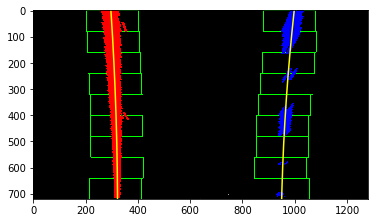

In [11]:
from Line import Line 

window_size = 5  

left_line = Line(n=window_size)
right_line = Line(n=window_size)

leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(leftx, lefty, rightx, righty, ploty)

## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, right_fitx, ploty,color='yellow')
    
fig = plt.figure(1)
plt.imshow(out_img)
plt.savefig('output_images/lanes_detection.jpg')

### 3.1 Curvature calculation

In [12]:
def measure_curvature_real(leftx, lefty, rightx, righty, ploty):
    """
    Calculates the curvature of polynomial functions in meters.
    """
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_curverad = (left_curverad + right_curverad)/2
    return left_curverad, right_curverad, avg_curverad

In [13]:
def overlay_img(undist, left_fitx, right_fitx, ploty, m_inv, avg_curverad, vehicle_offset):
    color_warp = np.zeros((720, 1280, 3), dtype='uint8')  # NOTE: Hard-coded image dimensions

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def label_img(overlay, avg_curverad, vehicle_offset):
    
    # Add labels for radious of curvature and vehicule offset
    radius_label = 'Average curvature: %.1f m' % avg_curverad
    result = cv2.putText(overlay, radius_label, (20,30), 0, 1, (255,255,255), 2, cv2.LINE_AA)

    offset_label = 'Vehicle offset from center: %.1f m' % vehicle_offset
    result = cv2.putText(overlay, offset_label, (20,60), 0, 1, (255,255,255), 2, cv2.LINE_AA)
    return result

def vehicle_offset(undist, left_fit, right_fit):
    y = undist.shape[0] - 1
    left_x = left_fit[0]*(y**2) + left_fit[1]*y + left_fit[2]
    right_x = right_fit[0]*(y**2) + right_fit[1]*y + right_fit[2]
    vehicle_offset = undist.shape[1]/2 - (left_x + right_x)/2

    xm_per_pix = 3.7/700
    vehicle_offset *= xm_per_pix

    return vehicle_offset

## 3.2 Detection Pipeline

In [14]:
from Line import Line

line_avg = 5  
left_line = Line(n=line_avg)
right_line = Line(n=line_avg)
left_curve, right_curve = 0., 0. 
left_lane_inds, right_lane_inds = None, None 

def detect_lane(img_in):
    global mtx, dist,left_line,right_line
   
    undist = cv2.undistort(img_in, mtx, dist, None, mtx)
    img = combined_threshold(undist)
    binary_warped, binary_unwarped, m, m_inv = perspective_transform(img)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    if not left_line.detected and not right_line.detected:
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
        # Fit a second order polynomial to each using `np.polyfit`
        left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(leftx, lefty, rightx, righty, ploty)
        left_line.detected = True 
        right_line.detected = True 
    else:  
        left_fit = left_line.get_best_fit()
        right_fit = right_line.get_best_fit()
        
        leftx, lefty, rightx, righty = search_around_poly(binary_warped, left_fit, right_fit)
        left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(leftx, lefty, rightx, righty, ploty)
        if left_fit is not None and right_fit is not None:
            left_curve, right_curve, avg_curverad = measure_curvature_real(leftx, lefty, rightx, righty, ploty)
        else:    
            left_line.detected = False
            right_line.detected = False
            
    left_curve, right_curve, avg_curverad = measure_curvature_real(leftx, lefty, rightx, righty, ploty)
    vehicle_offset = vehicle_offset(undist, left_fit, right_fit)
    overlay = overlay_img(undist, left_fitx, right_fitx, ploty, m_inv, avg_curverad, vehicle_offset)
    result = label_img(overlay, avg_curverad, vehicle_offset)
    return result


In [15]:
from moviepy.editor import VideoFileClip

def annotate_video(input_file, output_file):
    """ Given input_file video, save annotated video to output_file """
    video = VideoFileClip(input_file)
    annotated_video = video.fl_image(detect_lane)
    annotated_video.write_videofile(output_file, audio=False)

In [16]:
annotate_video('project_video.mp4', 'output_video.mp4')

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [04:11<00:00,  5.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 



In [17]:
annotate_video('challenge_video.mp4', 'output_video_challenge.mp4')

[MoviePy] >>>> Building video output_video_challenge.mp4
[MoviePy] Writing video output_video_challenge.mp4


100%|██████████| 485/485 [01:34<00:00,  5.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video_challenge.mp4 



In [18]:
annotate_video('harder_challenge_video.mp4', 'output_video_harder_challenge.mp4')

[MoviePy] >>>> Building video output_video_harder_challenge.mp4
[MoviePy] Writing video output_video_harder_challenge.mp4


100%|█████████▉| 1199/1200 [04:28<00:00,  4.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video_harder_challenge.mp4 

